کتابخانه های مورد نیاز

دانلود دیتاست مورد استفاده:   https://www.mediafire.com/file/j03djpy140rno4d/data.rar/file

In [278]:
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

وارد کردن دیتاست

In [279]:
data_dir = "data"  
categories = os.listdir(data_dir) 

داده‌ها و برچسب‌ها 

In [280]:
images = []
labels = []

فرمت‌های تصویری پشتیبانی‌شده

In [281]:
valid_formats = ('.jpg', '.png', '.gif', '.jpeg')

تغییر سایز

In [282]:
img_size = 64

پیش‌ پردازش تصاویر

In [283]:
for label, category in enumerate(categories):  
    category_path = os.path.join(data_dir, category)  
    for file in os.listdir(category_path):  
        if file.lower().endswith(valid_formats):  
            file_path = os.path.join(category_path, file)  
            try:  
                
                img = cv2.imread(file_path, cv2.IMREAD_COLOR)  
                if img is not None:  
                    img_resized = cv2.resize(img, (img_size, img_size))  
                    images.append(img_resized)  
                    labels.append(label)  
                else:  
                    print(f"Error loading image: {file_path}")  
            except Exception as e:  
                print(f"Error processing {file_path}: {e}") 

Error loading image: data\Sad\crying-sad.gif


 و نرمال سازی تبدیل به آرایه numpy 

In [284]:
images = np.array(images) / 255.0  
labels = np.array(labels)

ورود لیبل ها به صورت one hot

In [285]:
labels = to_categorical(labels, num_classes=len(categories))


تقسیم داده‌های آموزشی و آزمایشی

In [286]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


تعریف residual block

In [287]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    #convolution_1
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    #convolution_2
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # تنظیم shortcut اگر ابعاد نامتناسب باشد
    if strides != 1 or int(x.shape[-1]) != int(shortcut.shape[-1]):
        shortcut = Conv2D(filters, 1, strides=strides, padding='same')(shortcut)

    # اضافه کردن shortcut
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

تعریف لایه ورودی

In [288]:
input_layer = Input(shape=(img_size, img_size, 3))


لایه‌های ابتدایی

In [289]:
x = Conv2D(64, 7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

بلاک‌های باقیمانده

In [290]:
x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128, strides=2)
x = residual_block(x, 128)
x = residual_block(x, 256, strides=2)
x = residual_block(x, 256)
x = residual_block(x, 512, strides=2)
x = residual_block(x, 512)

لایه‌های نهایی

In [291]:
x = GlobalAveragePooling2D()(x)
output_layer = Dense(len(categories), activation='softmax')(x)

ساخت مدل 

In [292]:
model = Model(inputs=input_layer, outputs=output_layer)

کامپایل مدل

In [293]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

آموزش مدل

In [294]:
history = model.fit(X_train, y_train, epochs=35, batch_size=20, validation_data=(X_test, y_test))  


Epoch 1/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 575ms/step - accuracy: 0.4160 - loss: 2.3739 - val_accuracy: 0.3208 - val_loss: 1.6370
Epoch 2/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 489ms/step - accuracy: 0.6065 - loss: 0.8711 - val_accuracy: 0.3208 - val_loss: 1.9077
Epoch 3/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.6648 - loss: 0.8035 - val_accuracy: 0.3774 - val_loss: 2.2803
Epoch 4/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step - accuracy: 0.8005 - loss: 0.4765 - val_accuracy: 0.2642 - val_loss: 1.4653
Epoch 5/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.8422 - loss: 0.4611 - val_accuracy: 0.3208 - val_loss: 1.4301
Epoch 6/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.8341 - loss: 0.3715 - val_accuracy: 0.3774 - val_loss: 1.5292
Epoch 7/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 529ms/step - accuracy: 0.9434 - loss: 0.1546 - val_accuracy: 0.3019 - val_loss: 1.8213
Epoch 8/35
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 547ms/step - accuracy: 0.9713 - loss: 0.1127 - val_accuracy: 0

ارزیابی مدل

In [295]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5189 - loss: 2.4771
Test Accuracy: 52.83%


رسم نمودار

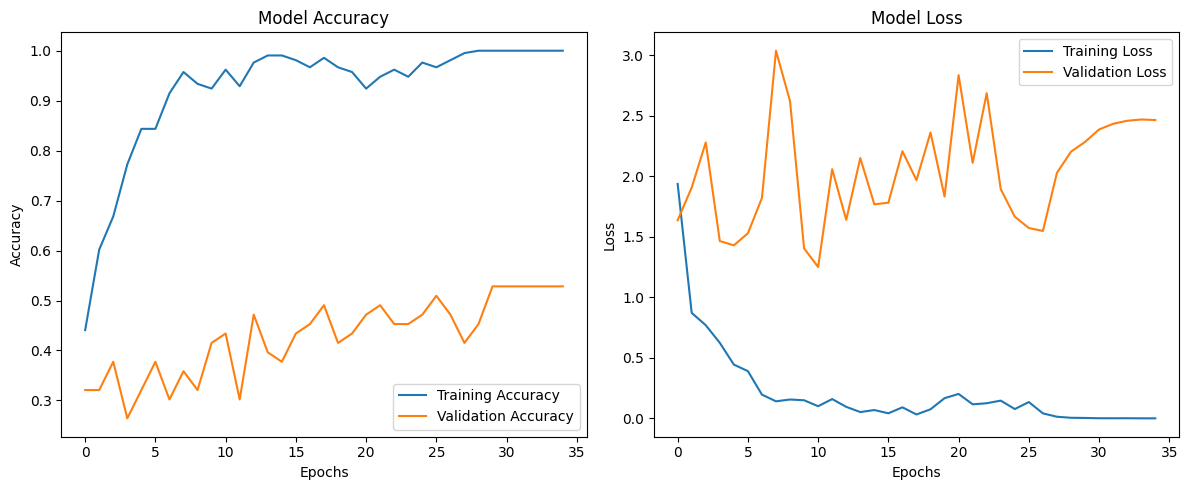

In [ ]:
# accuracy  
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Training Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')  
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  
plt.legend(loc='lower right')  

# loss  
plt.subplot(1, 2, 2)  
plt.plot(history.history['loss'], label='Training Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')  
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.legend(loc='upper right')  

#------------------------------------------------------------------

plt.tight_layout()  
plt.show()